In [6]:
# Voxel-based Ray Tracing
# No refraction for simplicity!
# Single point light source for simplicity!
# FB36 - 20130829

# See: http://code.activestate.com/recipes/578652-voxel-based-ray-tracing/

import math
from PIL import Image
from matplotlib import pyplot as plt

In [117]:
light = (-10.0, -10.0, -10.0)

ambientBrightness = 0.3 # between 0 and 1

# voxel-box size
box_w = 200; box_h = 200 ; box_d = 200

# each voxel can have RGB color
voxelRGB = [[[(0, 0, 0) for x in range(box_w)] for y in range(box_h)] for z in range(box_d)]

# each voxel can have an opacity coefficient 0 or 1 (for simplicity)
opacity = [[[0 for x in range(box_w)] for y in range(box_h)] for z in range(box_d)]

# each voxel can have a 3d normal unit vector (for reflections/refractions)
normal = [[[(0.0, 0.0, 0.0) for x in range(box_w)] for y in range(box_h)] for z in range(box_d)]

# each voxel can have a reflectivity coefficient between 0 and 1
reflectivity = [[[0.0 for x in range(box_w)] for y in range(box_h)] for z in range(box_d)]

In [118]:
def CombineColors(c0, c1, w):
    return (int(round(c0[0] + (c1[0] - c0[0]) * w)),
            int(round(c0[1] + (c1[1] - c0[1]) * w)),
            int(round(c0[2] + (c1[2] - c0[2]) * w)))
    
# 3D Reflection (all vectors are unit vectors)
def Reflection(normalVector, incidentRayVector):
    (nx, ny, nz) = normalVector
    (ix, iy, iz) = incidentRayVector
    dotProduct = nx * ix + ny * iy + nz * iz
    rx = ix - 2 * dotProduct * nx
    ry = iy - 2 * dotProduct * ny
    rz = iz - 2 * dotProduct * nz    
    return (rx, ry, rz)

def LightIntensity(surfaceVoxelCoordinates, surfaceNormalVector):
    (svx, svy, svz) = surfaceVoxelCoordinates
    (nx, ny, nz) = surfaceNormalVector
    (Lx, Ly, Lz) = light
    dx = Lx - svx
    dy = Ly - svy
    dz = Lz - svz
    d = math.sqrt(dx * dx + dy * dy + dz * dz)
    dx = dx / d; dy = dy / d; dz = dz / d # unit vector towards light
    cosT = nx * dx + ny * dy + nz * dz
    if cosT < 0.0: cosT = 0.0 # the surface faces away from the light source
    return cosT

def ShadowIntensity(rayX, rayY, rayZ):
    (Lx, Ly, Lz) = light
    dx = Lx - rayX
    dy = Ly - rayY
    dz = Lz - rayZ
    d = math.sqrt(dx * dx + dy * dy + dz * dz)
    dx = dx / d; dy = dy / d; dz = dz / d # unit vector towards light

    while True: # shadow ray tracing

        rayX += dx; rayY += dy; rayZ += dz # move the ray by 1 voxel

        rayXint = int(round(rayX))
        rayYint = int(round(rayY))
        rayZint = int(round(rayZ))

        # if ray goes outside of the voxel-box
        if rayXint < 0 or rayXint > box_w - 1 \
            or rayYint < 0 or rayYint > box_h - 1 \
            or rayZint < 0 or rayZint > box_d - 1:
            return 1.0

        # if ray hits an object
        if opacity[rayZint][rayYint][rayXint] == 1:
            # stop tracing here for simplicity
            return 0.0

        # if ray hits the light source
        vx = Lx - rayX
        vy = Ly - rayY
        vz = Lz - rayZ
        d = math.sqrt(vx * vx + vy * vy + vz * vz)
        if d < 1.0:
            return 1.0

# Ray Tracer (traces the ray and returns an RGB color)
def RayTrace(rayX, rayY, rayZ, dx, dy, dz):
    print((rayX, rayY, rayZ, dx, dy, dz))
    
    
    brightness = 1.0 # the ray has full brightness at the beginning
    color = (0, 0, 0)

    while True:

        rayX += dx; rayY += dy; rayZ += dz # move the ray by 1 voxel

        rayXint = int(round(rayX))
        rayYint = int(round(rayY))
        rayZint = int(round(rayZ))

        # if ray goes outside of the voxel-box
        if rayXint < 0 or rayXint > box_w - 1 \
            or rayYint < 0 or rayYint > box_h - 1 \
            or rayZint < 0 or rayZint > box_d - 1:
            return color

        # if ray hits an object
        if opacity[rayZint][rayYint][rayXint] == 1:

            # if ray hits a non-reflective object
            if reflectivity[rayZint][rayYint][rayXint] == 0.0:
                brightness *= ShadowIntensity(rayX, rayY, rayZ)
                brightness *= LightIntensity((rayX, rayY, rayZ), normal[rayZint][rayYint][rayXint])
                brightness = brightness * (1.0 - ambientBrightness) + ambientBrightness
                color = CombineColors(color, voxelRGB[rayZint][rayYint][rayXint], brightness)                
                return color

            # if ray hits a reflective object
            if reflectivity[rayZint][rayYint][rayXint] > 0.0:
                brightness *= reflectivity[rayZint][rayYint][rayXint]

                brightnessTemp = ShadowIntensity(rayX, rayY, rayZ)
                brightnessTemp *= LightIntensity((rayX, rayY, rayZ), normal[rayZint][rayYint][rayXint])
                brightnessTemp = brightnessTemp * (1.0 - ambientBrightness) + ambientBrightness
                colorTemp = voxelRGB[rayZint][rayYint][rayXint]
                colorTemp = (int(colorTemp[0] * brightnessTemp), \
                             int(colorTemp[1] * brightnessTemp), \
                             int(colorTemp[2] * brightnessTemp))

                color = CombineColors(color, colorTemp, \
                                      1.0 - reflectivity[rayZint][rayYint][rayXint])
                (dx, dy, dz) = Reflection(normal[rayZint][rayYint][rayXint], (dx, dy, dz))

In [119]:
# cx, cy, cz: center; r: radius (in voxels)
# rc: reflectivity coefficient between 0 and 1
def CreateMirrorSphere(cx, cy, cz, r):
    print("Creating mirror sphere...")
    # sphere is set of voxels which have distance = r to center
    for z in range(box_d):
        for y in range(box_h):
            for x in range(box_w):
                dx = x - cx
                dy = y - cy
                dz = z - cz
                d = math.sqrt(dx * dx + dy * dy + dz * dz)
                if abs(d - r) < 1.0:
                    voxelRGB[z][y][x] = (255, 255, 0)
                    opacity[z][y][x] = 1
                    normal[z][y][x] = (dx / d, dy / d, dz / d)
                    reflectivity[z][y][x] = 0.0
                else:
                    voxelRGB[z][y][x] = (0, 0, 0)
                    opacity[z][y][x] = 0
                    normal[z][y][x] = (0.0, 0.0, 0.0)
                    reflectivity[z][y][x] = 0.0
    
def CreateCheckerboardFloor(sqrX, sqrZ, colorRGB0, colorRGB1):
    print("Creating checkerboard floor...")
    for z in range(box_d):
        for x in range(box_w):
            if int(x / sqrX) % 2 != int(z / sqrZ) % 2: # xor
                voxelRGB[z][0][x] = colorRGB0
            else:
                voxelRGB[z][0][x] = colorRGB1
            opacity[z][0][x] = 1
            normal[z][0][x] = (0.0, 1.0, 0.0)
            reflectivity[z][0][x] = 0.0

def CreateScene():
    print("Creating scene...")
    CreateMirrorSphere(box_w / 2.0, box_h / 2.0, box_d / 2.0, 50.0)
    CreateCheckerboardFloor(20, 20, (255, 255, 0), (0, 0, 255))

CreateScene()

Creating scene...
Creating mirror sphere...
Creating checkerboard floor...


0.0%
(0.0, 0.0, -100, 0.0, 0.0, 1.0)
(1.0050251256281513, 0.0, -100, 0.0, 0.0, 1.0)
(2.010050251256274, 0.0, -100, 0.0, 0.0, 1.0)
(3.0150753768844254, 0.0, -100, 0.0, 0.0, 1.0)
(4.0201005025125625, 0.0, -100, 0.0, 0.0, 1.0)
(5.0251256281406995, 0.0, -100, 0.0, 0.0, 1.0)
(6.030150753768851, 0.0, -100, 0.0, 0.0, 1.0)
(7.035175879396988, 0.0, -100, 0.0, 0.0, 1.0)
(8.040201005025125, 0.0, -100, 0.0, 0.0, 1.0)
(9.045226130653262, 0.0, -100, 0.0, 0.0, 1.0)
(10.050251256281399, 0.0, -100, 0.0, 0.0, 1.0)
(11.05527638190955, 0.0, -100, 0.0, 0.0, 1.0)
(12.060301507537687, 0.0, -100, 0.0, 0.0, 1.0)
(13.065326633165824, 0.0, -100, 0.0, 0.0, 1.0)
(14.070351758793976, 0.0, -100, 0.0, 0.0, 1.0)
(15.075376884422113, 0.0, -100, 0.0, 0.0, 1.0)
(16.08040201005025, 0.0, -100, 0.0, 0.0, 1.0)
(17.085427135678387, 0.0, -100, 0.0, 0.0, 1.0)
(18.090452261306538, 0.0, -100, 0.0, 0.0, 1.0)
(19.095477386934675, 0.0, -100, 0.0, 0.0, 1.0)
(20.100502512562812, 0.0, -100, 0.0, 0.0, 1.0)
(21.105527638190964, 0.0, -100

(106.53266331658291, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(107.53768844221105, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(108.5427135678392, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(109.54773869346734, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(110.55276381909547, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(111.55778894472363, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(112.56281407035176, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(113.5678391959799, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(114.57286432160804, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(115.57788944723617, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(116.58291457286433, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(117.58793969849246, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(118.5929648241206, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(119.59798994974875, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(120.60301507537689, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(121.60804020100502, 10.050251256281399, -100, 0.0, 0.0, 1.0)
(122.613065

(50.25125628140704, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(51.256281407035175, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(52.26130653266331, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(53.266331658291456, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(54.2713567839196, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(55.27638190954774, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(56.28140703517588, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(57.28643216080402, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(58.29145728643216, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(59.2964824120603, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(60.301507537688444, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(61.30653266331658, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(62.31155778894472, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(63.31658291457287, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(64.321608040201, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(65.32663316582915, 20.100502512562812, -100, 0.0, 0.0, 1.0)
(66.33165829145729, 20.10

(161.80904522613065, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(162.8140703517588, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(163.81909547738692, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(164.82412060301507, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(165.8291457286432, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(166.83417085427135, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(167.8391959798995, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(168.84422110552765, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(169.84924623115577, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(170.8542713567839, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(171.85929648241205, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(172.8643216080402, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(173.86934673366835, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(174.8743718592965, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(175.87939698492463, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(176.88442211055275, 27.1356783919598, -100, 0.0, 0.0, 1.0)
(177.8894472361809, 27.1356783919598, -100, 0.

(90.45226130653266, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(91.4572864321608, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(92.46231155778895, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(93.46733668341709, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(94.47236180904522, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(95.47738693467336, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(96.48241206030151, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(97.48743718592965, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(98.49246231155779, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(99.49748743718592, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(100.50251256281408, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(101.50753768844221, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(102.51256281407035, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(103.51758793969849, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(104.52261306532664, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(105.52763819095478, 37.1859296482412, -100, 0.0, 0.0, 1.0)
(106.53266331658291, 37.1859296482412, -100, 0.0, 0

(71.35678391959799, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(72.36180904522612, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(73.36683417085428, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(74.37185929648241, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(75.37688442211055, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(76.3819095477387, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(77.38693467336684, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(78.39195979899498, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(79.39698492462311, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(80.40201005025125, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(81.4070351758794, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(82.41206030150754, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(83.41708542713567, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(84.42211055276383, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(85.42713567839196, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(86.4321608040201, 47.23618090452262, -100, 0.0, 0.0, 1.0)
(87.43718592964824, 47.23618090452262, -100

(108.5427135678392, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(109.54773869346734, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(110.55276381909547, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(111.55778894472363, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(112.56281407035176, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(113.5678391959799, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(114.57286432160804, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(115.57788944723617, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(116.58291457286433, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(117.58793969849246, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(118.5929648241206, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(119.59798994974875, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(120.60301507537689, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(121.60804020100502, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(122.61306532663316, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(123.6180904522613, 57.28643216080402, -100, 0.0, 0.0, 1.0)
(124.62311557788945, 57.2864

(42.21105527638191, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(43.21608040201005, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(44.221105527638194, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(45.226130653266324, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(46.231155778894475, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(47.23618090452262, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(48.24120603015075, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(49.246231155778894, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(50.25125628140704, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(51.256281407035175, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(52.26130653266331, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(53.266331658291456, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(54.2713567839196, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(55.27638190954774, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(56.28140703517588, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(57.28643216080402, 67.33668341708542, -100, 0.0, 0.0, 1.0)
(58.29145728643216, 67.336683417085

(58.29145728643216, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(59.2964824120603, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(60.301507537688444, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(61.30653266331658, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(62.31155778894472, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(63.31658291457287, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(64.321608040201, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(65.32663316582915, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(66.33165829145729, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(67.33668341708542, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(68.34170854271358, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(69.34673366834171, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(70.35175879396985, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(71.35678391959799, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(72.36180904522612, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(73.36683417085428, 76.3819095477387, -100, 0.0, 0.0, 1.0)
(74.37185929648241, 76.3819095477387, -100, 0.0, 0.0, 1.0)

(144.72361809045225, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(145.7286432160804, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(146.73366834170855, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(147.7386934673367, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(148.74371859296483, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(149.74874371859295, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(150.7537688442211, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(151.75879396984925, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(152.76381909547737, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(153.76884422110552, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(154.77386934673368, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(155.7788944723618, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(156.78391959798995, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(157.7889447236181, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(158.79396984924622, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(159.79899497487438, 85.42713567839196, -100, 0.0, 0.0, 1.0)
(160.8040201005025, 85.427135

(143.71859296482413, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(144.72361809045225, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(145.7286432160804, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(146.73366834170855, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(147.7386934673367, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(148.74371859296483, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(149.74874371859295, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(150.7537688442211, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(151.75879396984925, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(152.76381909547737, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(153.76884422110552, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(154.77386934673368, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(155.7788944723618, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(156.78391959798995, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(157.7889447236181, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(158.79396984924622, 94.47236180904522, -100, 0.0, 0.0, 1.0)
(159.79899497487438, 94.47236

(58.29145728643216, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(59.2964824120603, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(60.301507537688444, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(61.30653266331658, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(62.31155778894472, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(63.31658291457287, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(64.321608040201, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(65.32663316582915, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(66.33165829145729, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(67.33668341708542, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(68.34170854271358, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(69.34673366834171, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(70.35175879396985, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(71.35678391959799, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(72.36180904522612, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(73.36683417085428, 105.52763819095478, -100, 0.0, 0.0, 1.0)
(74.37185929648241, 105.52

(56.28140703517588, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(57.28643216080402, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(58.29145728643216, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(59.2964824120603, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(60.301507537688444, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(61.30653266331658, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(62.31155778894472, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(63.31658291457287, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(64.321608040201, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(65.32663316582915, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(66.33165829145729, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(67.33668341708542, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(68.34170854271358, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(69.34673366834171, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(70.35175879396985, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(71.35678391959799, 113.5678391959799, -100, 0.0, 0.0, 1.0)
(72.36180904522612, 113.5678391959799, -10

(187.9396984924623, 123.6180904522613, -100, 0.0, 0.0, 1.0)
(188.94472361809045, 123.6180904522613, -100, 0.0, 0.0, 1.0)
(189.9497487437186, 123.6180904522613, -100, 0.0, 0.0, 1.0)
(190.95477386934675, 123.6180904522613, -100, 0.0, 0.0, 1.0)
(191.95979899497488, 123.6180904522613, -100, 0.0, 0.0, 1.0)
(192.964824120603, 123.6180904522613, -100, 0.0, 0.0, 1.0)
(193.96984924623115, 123.6180904522613, -100, 0.0, 0.0, 1.0)
(194.9748743718593, 123.6180904522613, -100, 0.0, 0.0, 1.0)
(195.97989949748745, 123.6180904522613, -100, 0.0, 0.0, 1.0)
(196.98492462311557, 123.6180904522613, -100, 0.0, 0.0, 1.0)
(197.98994974874373, 123.6180904522613, -100, 0.0, 0.0, 1.0)
(198.99497487437185, 123.6180904522613, -100, 0.0, 0.0, 1.0)
(200.0, 123.6180904522613, -100, 0.0, 0.0, 1.0)
62.311557788944725%
(0.0, 124.62311557788945, -100, 0.0, 0.0, 1.0)
(1.0050251256281513, 124.62311557788945, -100, 0.0, 0.0, 1.0)
(2.010050251256274, 124.62311557788945, -100, 0.0, 0.0, 1.0)
(3.0150753768844254, 124.6231155778

(15.075376884422113, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(16.08040201005025, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(17.085427135678387, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(18.090452261306538, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(19.095477386934675, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(20.100502512562812, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(21.105527638190964, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(22.110552763819086, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(23.115577889447238, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(24.120603015075375, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(25.125628140703512, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(26.130653266331663, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(27.1356783919598, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(28.140703517587937, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(29.14572864321609, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(30.150753768844226, 133.6683417085427, -100, 0.0, 0.0, 1.0)
(31.155778894472363, 133.668

(146.73366834170855, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(147.7386934673367, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(148.74371859296483, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(149.74874371859295, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(150.7537688442211, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(151.75879396984925, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(152.76381909547737, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(153.76884422110552, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(154.77386934673368, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(155.7788944723618, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(156.78391959798995, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(157.7889447236181, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(158.79396984924622, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(159.79899497487438, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(160.8040201005025, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(161.80904522613065, 142.71356783919597, -100, 0.0, 0.0, 1.0)
(162.81407035

(93.46733668341709, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(94.47236180904522, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(95.47738693467336, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(96.48241206030151, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(97.48743718592965, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(98.49246231155779, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(99.49748743718592, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(100.50251256281408, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(101.50753768844221, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(102.51256281407035, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(103.51758793969849, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(104.52261306532664, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(105.52763819095478, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(106.53266331658291, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(107.53768844221105, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(108.5427135678392, 151.75879396984925, -100, 0.0, 0.0, 1.0)
(109.54773869346

(160.8040201005025, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(161.80904522613065, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(162.8140703517588, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(163.81909547738692, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(164.82412060301507, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(165.8291457286432, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(166.83417085427135, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(167.8391959798995, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(168.84422110552765, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(169.84924623115577, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(170.8542713567839, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(171.85929648241205, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(172.8643216080402, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(173.86934673366835, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(174.8743718592965, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(175.87939698492463, 161.80904522613065, -100, 0.0, 0.0, 1.0)
(176.8844221105

(21.105527638190964, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(22.110552763819086, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(23.115577889447238, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(24.120603015075375, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(25.125628140703512, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(26.130653266331663, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(27.1356783919598, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(28.140703517587937, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(29.14572864321609, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(30.150753768844226, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(31.155778894472363, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(32.1608040201005, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(33.16582914572864, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(34.17085427135679, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(35.175879396984925, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(36.18090452261307, 171.85929648241205, -100, 0.0, 0.0, 1.0)
(37.185929648241

(48.24120603015075, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(49.246231155778894, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(50.25125628140704, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(51.256281407035175, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(52.26130653266331, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(53.266331658291456, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(54.2713567839196, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(55.27638190954774, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(56.28140703517588, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(57.28643216080402, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(58.29145728643216, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(59.2964824120603, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(60.301507537688444, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(61.30653266331658, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(62.31155778894472, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(63.31658291457287, 179.8994974874372, -100, 0.0, 0.0, 1.0)
(64.321608040201, 179.8994974874372, -

(48.24120603015075, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(49.246231155778894, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(50.25125628140704, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(51.256281407035175, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(52.26130653266331, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(53.266331658291456, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(54.2713567839196, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(55.27638190954774, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(56.28140703517588, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(57.28643216080402, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(58.29145728643216, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(59.2964824120603, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(60.301507537688444, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(61.30653266331658, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(62.31155778894472, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(63.31658291457287, 188.94472361809045, -100, 0.0, 0.0, 1.0)
(64.321608040201, 188.

(157.7889447236181, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(158.79396984924622, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(159.79899497487438, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(160.8040201005025, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(161.80904522613065, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(162.8140703517588, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(163.81909547738692, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(164.82412060301507, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(165.8291457286432, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(166.83417085427135, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(167.8391959798995, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(168.84422110552765, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(169.84924623115577, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(170.8542713567839, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(171.85929648241205, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(172.8643216080402, 197.98994974874373, -100, 0.0, 0.0, 1.0)
(173.8693467336

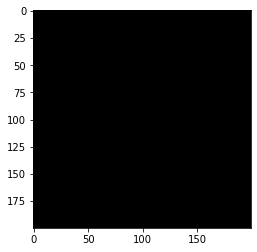

In [120]:
img_x = 200
img_y = 200
image = Image.new("RGB", (img_x, img_y))
pixels = image.load()

for ky in range(img_y):
    print(str(100 * ky / (img_y - 1)).zfill(3) + "%")
    for kx in range(img_x):
        ux = (kx - (img_x-1)/2.) / (img_x-1)
        uy = (ky - (img_y-1)/2.) / (img_y-1)
        px = box_w/2. + box_w * ux
        py = box_h/2. + box_h * uy
        pz = -100
        dx = 0.0
        dy = 0.0
        dz = 1.0
        d = math.sqrt(dx * dx + dy * dy + dz * dz)
        dx = dx / d; dy = dy / d; dz = dz / d # ray unit vector
        pixels[kx, img_y - ky - 1] = RayTrace(px, py, pz, dx, dy, dz)

plt.imshow(image)
plt.show()